In [ ]:
# Interactive
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Standard library
import warnings

import joblib

# Data
import numpy as np
import pandas as pd

# Custom transformers
import transformers as tfs
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    log_loss,
    make_scorer,
)
from sklearn.model_selection import (
    HalvingRandomSearchCV,
    ParameterGrid,
    StratifiedKFold,
)

# Visualization
# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

print("XGB Version", xgb.__version__)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


XGB Version 1.7.2


## Global Settings

In [3]:
# Random state
seed = 12
rs = np.random.RandomState(seed)

# Train and test data paths
train_path = "../data/train_test/"
test_path = "../data/train_test/"

# Other paths
model_path = "../outputs/models/"
plot_path = "../outputs/plots/"

# K-fold
folds = 5

# Top x important features to visualize
top_num_features = 20

warnings.filterwarnings("ignore")

## Data

In [4]:
train_X, train_y = (
    pd.read_parquet(train_path + "train_X.parquet"),
    pd.read_parquet(train_path + "train_y.parquet").to_numpy().ravel(),
)
test_X, test_y = (
    pd.read_parquet(test_path + "test_X.parquet"),
    pd.read_parquet(test_path + "test_y.parquet").to_numpy().ravel(),
)

In [5]:
train_X.shape, train_y.shape

((32950, 20), (32950,))

In [6]:
test_X.shape, test_y.shape

((8238, 20), (8238,))

## Pipeline

We create the following pipelines:

* There are no explicit missing values in both the training and test data; in addition, xgboost can handle missing values by default. However, if we expect future unseen data to contain missing values that need special handling, then we may need to invest in writing and testing additional custom transformers to include in the preprocessing steps.

* Because the learners are trees, it isn't necessary to perform feature scaling or normalization.

In [7]:
preprocessor = Pipeline(
    [
        ("drop_duration", tfs.ColumnDropperTransformer(["duration"])),
        (
            "cat_feature_engineer",
            FunctionTransformer(tfs.cat_feature_engineer, validate=False),
        ),  # One hyperparameter: encode_type
        (
            "num_feature_engineer",
            FunctionTransformer(tfs.num_feature_engineer, validate=False),
        ),  # One hyperparameter: switch
        (
            "recursive_feature_selection",
            RFE(
                DecisionTreeClassifier(random_state=rs),
                n_features_to_select=0.5,
                step=0.2,
                verbose=0,
            ),
        ),
    ]
)
label_encoder = LabelEncoder()

In [8]:
# Write preprocessor and label encoder to disk for later use
joblib.dump(preprocessor, "../outputs/pipeline/preprocessor.joblib")
joblib.dump(label_encoder, "../outputs/pipeline/label_encoder.joblib")

['../outputs/pipeline/preprocessor.joblib']

['../outputs/pipeline/label_encoder.joblib']

In [ ]:
train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.transform(test_y)
train_y, test_y

Next, we construct a final modeling pipeline that includes the gradient-boosting classifier, which we can pass into grid search. Note that the `eval_metric` parameter below is assumed to be a cost function and by default XGBoost will minimize the result during early stopping. This is not the same the `scoring` parameter commonly used in scikit-learn.

In [69]:
# We will fix these xgboost classifier parameters
fixed_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "verbosity": 1,
    "random_state": rs,
    "n_jobs": -1,
    "eval_metric": make_scorer(
        log_loss, labels=[0, 1]
    ),  # More robust to imbalance, used for monitoring the training result and early stopping
}

modeling_pipe = Pipeline(
    [
        (
            "preprocessor",
            preprocessor,
        ),  # This step is in and of itself a pipeline (nested) which needs special handling in GridSearchCV
        ("classifier", xgb.XGBClassifier(**fixed_params)),
    ]
)
joblib.dump(modeling_pipe, "../outputs/pipeline/modeling_pipeline.joblib")
modeling_pipe

['../outputs/pipeline/modeling_pipeline.joblib']

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('drop_duration',
                                  ColumnDropperTransformer(columns=['duration'])),
                                 ('cat_feature_engineer',
                                  FunctionTransformer(func=<function cat_feature_engineer at 0x171ace040>)),
                                 ('num_feature_engineer',
                                  FunctionTransformer(func=<function num_feature_engineer at 0x171ace280>)),
                                 ('recursive_feature_selection',
                                  RFE(estimator=De...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=1505292720, ...))])

Due to the nested nature of the pipeline, it will be easier to see the entire list of parameters with their tags, so we can select the hyperparameter we need to include in a grid search. 

In [70]:
hp = sorted(modeling_pipe.get_params().keys())
len(hp)

86

In [71]:
hp

['classifier',
 'classifier__base_score',
 'classifier__booster',
 'classifier__callbacks',
 'classifier__colsample_bylevel',
 'classifier__colsample_bynode',
 'classifier__colsample_bytree',
 'classifier__early_stopping_rounds',
 'classifier__enable_categorical',
 'classifier__eval_metric',
 'classifier__feature_types',
 'classifier__gamma',
 'classifier__gpu_id',
 'classifier__grow_policy',
 'classifier__importance_type',
 'classifier__interaction_constraints',
 'classifier__learning_rate',
 'classifier__max_bin',
 'classifier__max_cat_threshold',
 'classifier__max_cat_to_onehot',
 'classifier__max_delta_step',
 'classifier__max_depth',
 'classifier__max_leaves',
 'classifier__min_child_weight',
 'classifier__missing',
 'classifier__monotone_constraints',
 'classifier__n_estimators',
 'classifier__n_jobs',
 'classifier__num_parallel_tree',
 'classifier__objective',
 'classifier__predictor',
 'classifier__random_state',
 'classifier__reg_alpha',
 'classifier__reg_lambda',
 'classifier

## Hyperparameter Tuning

We will first use halving grid search cv to try to find the best combination of hyperparameter for the gradient boosting classifier. Note again, this is done without any over or under-sampling. We will conduct another CV to validate our model once we have solidified a list of parameters to use for the classifier.

In [72]:
# Grid of hyperparameter values
param_grid = {
    # XGBoost hyperparameter to tune
    "classifier__learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "classifier__n_estimators": list(range(50, 350, 50)),  # Number of trees
    "classifier__max_depth": list(range(3, 11, 2)),  # Tree size
    "classifier__gamma": [0, 3],  # Regularization complexity
    "classifier__colsample_bytree": [
        0.4,
        0.6,
        0.8,
        1.0,
    ],  # Subsample ratio of columns (features) when constructing each tree
    "classifier__subsample": [
        0.5,
        0.75,
        1.0,
    ],  # Subsample ratio of the rows (training instances) to safeguard against overfitting
}

The total number of models that could be trained is $k$ (k fold csv) times total number of parameters (product of all values in the grid):

In [73]:
len(ParameterGrid(param_grid=param_grid)) * folds

11520

The randomized halving grid search uses successive halving to reduce the training time. Note that the `XGBClassifier` estimator has its own `score` method, which would be used if no `scoring` argument is specified below. 

In [74]:
search = HalvingRandomSearchCV(
    estimator=modeling_pipe,
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=folds),
    scoring=make_scorer(
        f1_score, average="weighted", labels=[0, 1], zero_division=0
    ),  # Alters 'macro f1' to be more robust to class imbalance
    refit=True,  # Get best estimator upon completion
    random_state=rs,
    verbose=1,
    n_jobs=-1,  # Use all processors
).fit(train_X, train_y)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 20
max_resources_: 32950
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1647
n_resources: 20
Fitting 5 folds for each of 1647 candidates, totalling 8235 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

----------
iter: 1
n_candidates: 549
n_resources: 60
Fitting 5 folds for each of 549 candidates, totalling 2745 fits
----------
iter: 2
n_candidates: 183
n_resources: 180
Fitting 5 folds for each of 183 candidates, totalling 915 fits
----------
iter: 3
n_candidates: 61
n_resources: 540
Fitting 5 folds for each of 61 candidates, totalling 305 fits
----------
iter: 4
n_candidates: 21
n_resources: 1620
Fitting 5 folds for each of 21 candidates, totalling 105 fits
----------
iter: 5
n_candidates: 7
n_resources: 4860
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 6
n_candidates: 3
n_resources: 14580
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [76]:
# Save base model to disk
joblib.dump(
    search.best_estimator_["classifier"], model_path + "baseline_model.joblib.dat"
)

['../outputs/models/baseline_model.joblib.dat']

In [78]:
# Save stored pipeline
joblib.dump(search, "../outputs/pipeline/tuned_pipeline_trained.joblib")

['../outputs/pipeline/tuned_pipeline_trained.joblib']

In [79]:
# Best model whose parameters we will use to run manual k-fold cross validation
model = search.best_estimator_["classifier"]
# Preprocessor trained on training data, which we can use to transform test data
preprocessor_trained = search.best_estimator_["preprocessor"]
# Trained rfe for getting the feature names
rfe_trained = search.best_estimator_["preprocessor"]["recursive_feature_selection"]
type(model), type(preprocessor_trained), type(rfe_trained)

(xgboost.sklearn.XGBClassifier,
 sklearn.pipeline.Pipeline,
 sklearn.feature_selection._rfe.RFE)

## Quick Evaluation

We can examine the `model` returned by the randomized halving grid search. We are not evaluating the model in a robust way (via CV) just yet, but we can get a preliminary sense of how this model is performing.

In [133]:
balanced = balanced_accuracy_score(
    y_true=test_y,
    y_pred=model.predict(preprocessor_trained.transform(test_X)),
    adjusted=False,
)
balanced

0.5854556818717864

Alternatively, we can set adjusted to true. With `adjusted=True`, balanced accuracy reports the relative increase from balanced accuracy.

* When true, the result is adjusted for chance, so that random performance would score 0, while keeping perfect performance at a score of 1. 
  
* In the binary case, this is also known as *Youden’s J statistic*, or informedness. 

* Instead of taking values from 0 to 1, setting `adjusted=True` rescales the range of the score from $\frac{1}{1-\text{number of classes}}=-1$ (number of classes is 2 in our case) to 1.

In [134]:
balanced_adj = balanced_accuracy_score(
    y_true=test_y,
    y_pred=model.predict(preprocessor_trained.transform(test_X)),
    adjusted=True,
)
balanced_adj

0.17091136374357285

Compare these to the simple accuracy score:

In [107]:
accuracy_score(
    y_true=test_y,
    y_pred=model.predict(preprocessor_trained.transform(test_X)),
)

0.898761835396941

In [108]:
# Using the estimator's own scoring function
model.score(X=preprocessor_trained.transform(test_X), y=test_y)

0.898761835396941

Finally, we can compare this to the zero rule benchmark which simply predicts the most frequently occurring classification in a set of data.

In [114]:
# A classifier that always predicts the majority class (0)
test_y_zeror = np.zeros_like(test_y)
test_y_zeror.sum()
test_y_zeror

0

array([0, 0, 0, ..., 0, 0, 0])

In [136]:
print(
    f"Balanced accuracy (majority class classifier): {balanced_accuracy_score(y_true=test_y, y_pred=test_y_zeror, adjusted=False)}",
    f"\nBalanced accuracy (boosted tree): {balanced.round(4)}",
    f"\nBalanced accuracy (majority class classifier adjusted for chance): {balanced_accuracy_score(y_true=test_y, y_pred=test_y_zeror, adjusted=True)}",
    f"\nBalanced accuracy (boosted tree adjusted for change): {balanced_adj.round(4)}",
)

Balanced accuracy (majority class classifier): 0.5 
Balanced accuracy (boosted tree): 0.5855 
Balanced accuracy (majority class classifier adjusted for chance): 0.0 
Balanced accuracy (boosted tree adjusted for change): 0.1709


As can be seen, our model outperforms that zero rule, but perhaps only slightly.

## Quick Feature Importance

We would like to examine the feature importance plot to evaluate how successful our feature engineering was. Below, we plot the top 20 importance features:

In [148]:
feat_imp = pd.DataFrame(
    {
        "feat_name": rfe_trained.get_feature_names_out(),
        "gains": model.feature_importances_,
    }
)
feat_imp.sort_values(by="gains", ascending=True, inplace=True)
feat_imp

,feat_name,gains
1,marital,0.000000
42,poutcome_std,0.000000
41,previous_max,0.000000
31,month_last,0.000000
4,housing,0.003098
51,euribor3m_min,0.004959
2,education,0.005317
34,day_of_week_last,0.005543
0,job,0.005660
27,loan_std,0.005954


<AxesSubplot:ylabel='feat_name'>

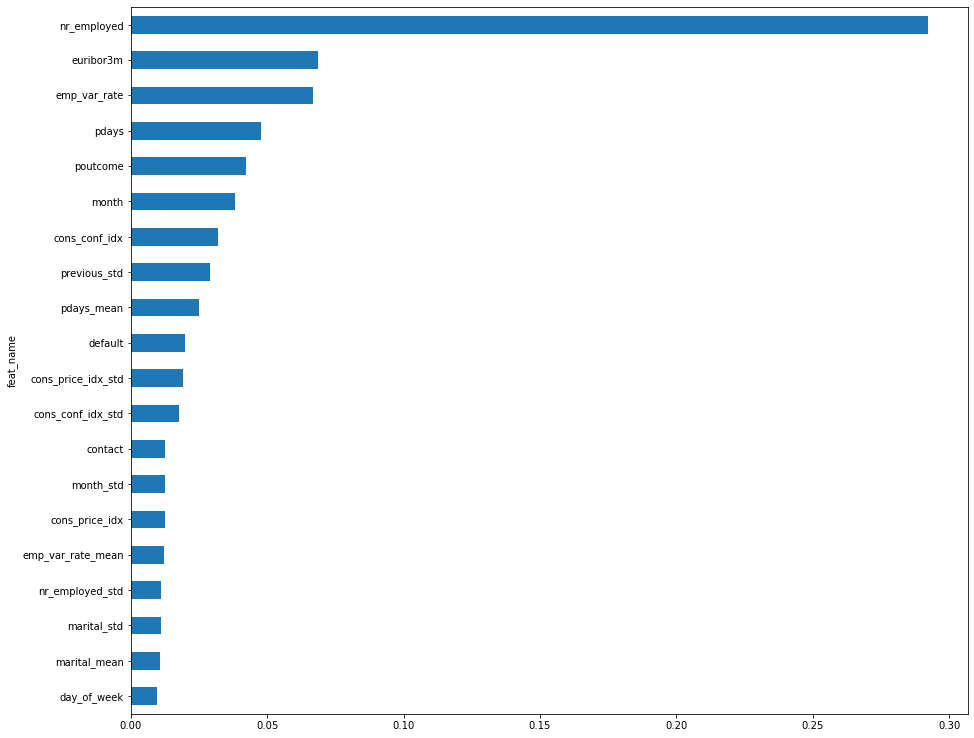

In [171]:
# Plot
feat_imp.iloc[-top_num_features:].plot(
    kind="barh", x="feat_name", y="gains", figsize=(15, 13), legend=False
)

Some of our engineered features certainly made it up the list. For instance, we can compute the percentage of engineered features among the top 20 most important features:

In [186]:
top_names = feat_imp.iloc[-top_num_features:].feat_name.to_list()
num_eng_feat = len(
    [
        name
        for name in top_names
        if any(map(name.__contains__, ["_mean", "_std", "_last", "_max", "_min"]))
    ]
)
print(
    f"{int(((num_eng_feat / len(top_names)) * 100))}% of the top {top_num_features} features are engineered from numerical features, not including count of categorical features"
)

45% of the top 20 features are engineered from numerical features, not including count of categorical features
